In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import json

from os.path import join

In [5]:
artist_csv_path = './artist_df.csv'
artist_df = pd.read_csv(artist_csv_path)
# aid -> artist id
# nid -> node id
aid_nid_map = {}
def add_aid_nid_mapping(aid_nid_map, aid, nid):
    aid_nid_map[aid] = nid
    return nid

In [3]:
artist_df.head()

,artist_id,artist_name,total_plays,num_listeners,play_ratio,track_freq,top_listeners,genres
0,AR02YGA1187B9B8AC4,Bersuit Vergarabat,3627,1269,2.858156,"{'TRACFXL128F930B28B': 3020, 'TRADFOQ128F93354...",{'8ccdf9ff4c0ce970e843c49ebf134942ebb74196': 3...,"['argentine rock', 'latin alternative', 'latin..."
1,AR035N21187FB3938E,BT,1391,63,22.079365,"{'TRAHXMC128F4267B70': 147, 'TRAKXNZ128F931DC2...",{'8e0dd300ccb1c2d8c64d1b389102e9a7fc4c034c': 2...,"['edm', 'pop dance', 'progressive house', 'pro..."
2,AR03BDP1187FB5B324,Britney Spears,9419,86,109.523256,"{'TRACYCJ128F9309246': 153, 'TRAEBXS128F429933...",{'68c98485da1b49b89377f0135590a203bf3a1ae3': 1...,"['dance pop', 'pop', 'pop rap', 'post-teen pop']"
3,AR040QX1187FB4CFE1,Alexisonfire,1528,474,3.223629,"{'TRAPGKY128F42972A9': 1144, 'TRAVHCL128F93015...",{'bf0503aad11e3ba0b8fd5a224b1b3cc9be0ccdfa': 4...,"['canadian post-hardcore', 'canadian rock', 'm..."
4,AR048JZ1187B9AEB85,Yellowcard,2872,1136,2.528169,{'TRAUWFN128F1462E09': 2872},{'6be2ac4fa0478867e2827870fc925f623c2fb261': 1...,"['bow pop', 'emo', 'pop punk', 'pop rock', 'so..."


In [38]:
artist_df['node_id'] = artist_df.apply(lambda row: add_aid_nid_mapping(aid_nid_map, row['artist_id'], row.name), axis = 1)
nid_aid_map = {nid: aid for (aid, nid) in aid_nid_map.items()}
nid_list = artist_df['node_id'].tolist()
# This creates a graph in which there is an undirected edge between each of the nodes
artist_graph = nx.complete_graph(len(nid_list))

In [41]:
# Add the node attributes to the graph
node_attrs_dict = {}
for nid in nid_list:
    row = artist_df.iloc[nid]
    artist_attr_dict = {
        'artist_name': row['artist_name'],
        'total_plays': row['total_plays'],
        'num_listeners': row['num_listeners'],
        'play_ratio': row['play_ratio']
    }
    genres = row['genres'].replace("[", "").replace("]", "").replace("\'", "").split(', ')
    track_freq = json.loads(row['track_freq'].replace("\'", "\""))
    top_listeners = json.loads(row['top_listeners'].replace("\'", "\""))
    artist_attr_dict['genres'], artist_attr_dict['track_freq'], artist_attr_dict['top_listeners'] = \
    genres, track_freq, top_listeners
    node_attrs_dict[nid] = artist_attr_dict
nx.set_node_attributes(artist_graph, node_attrs_dict)

In [42]:
# create edge attributes and add them to the graph
edge_attribute_list = []
for nid in nid_list[:-1]:
    for other_nid in nid_list[nid+1:]:
        nid_attr_dict, other_nid_attr_dict = artist_graph.nodes[nid], artist_graph.nodes[other_nid]
        total_plays_abs_diff = abs(nid_attr_dict['total_plays'] - other_nid_attr_dict['total_plays'])
        num_listeners_abs_diff = abs(nid_attr_dict['num_listeners'] - other_nid_attr_dict['num_listeners'])
        play_ratio_abs_diff = abs(nid_attr_dict['play_ratio'] - other_nid_attr_dict['play_ratio'])
        edge_attr_dict = {
            'total_plays_abs_diff': total_plays_abs_diff,
            'num_listeners_abs_diff': num_listeners_abs_diff,
            'play_ratio': play_ratio_abs_diff
        }
        edge = (nid, other_nid, edge_attr_dict)
        edge_attribute_list.append(edge)
artist_graph.add_edges_from(edge_attribute_list)

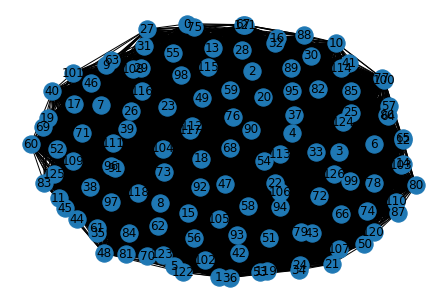

In [43]:
nx.draw(artist_graph, with_labels=True)
plt.savefig('test_graph_draw_artist.png')